# Toy Problem Demo

## Scope

Overview of Benchq:
- inputs and outputs
- components:
  - Transpilation (pyliqtr)
  - Jabalizer/ICM
  - Min code distance finding
  - Substrate scheduling


Wait a little for TA 1 and TA 1.5

### Goal: Introduction to Benchq Tool for Resource Estimation

## Agenda
- Quick overview of Benchq usage.
- What is a circuit graph? How do we produce them?
- How do circuit graphs help get resource estimates?
- Look at some pretty plots
  - Preparing a GHZ state
  - The fully connected graph

## Overview of Benchq Usage

What are the inputs and outputs?

In [10]:
%matplotlib inline  
from qiskit.circuit import QuantumCircuit
import os
import json
import networkx as nx

from benchq import BasicArchitectureModel
from benchq.compilation import get_algorithmic_graph, pyliqtr_transpile_to_clifford_t
from benchq.resource_estimation.graph_compilation import (
    get_resource_estimations_for_graph,
)

Input a circuit and some parameters describing your computer.

Simple circuit for this demo.

In [3]:
demo_circuit = QuantumCircuit.from_qasm_file("rotation_cnot.qasm")
architecture_model = BasicArchitectureModel(
    physical_gate_error_rate=1e-3,
    physical_gate_time_in_seconds=1e-6,
)

Next, transpile into Clifford + T.

In [4]:
clifford_t_circuit = pyliqtr_transpile_to_clifford_t(demo_circuit, synthesis_accuracy=1e-6)
print(clifford_t_circuit)

Circuit(operations=[H(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), S(0), T(0), H(0), S(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(0), T(0), H(

Transform circuit into graph.

In [5]:
circuit_graph = get_algorithmic_graph(clifford_t_circuit)

With this use this graph to make resource estimates.

In [6]:
resource_estimates = get_resource_estimations_for_graph(circuit_graph, architecture_model)
print(resource_estimates)

pre-mapping optimization took - 1.0859999974854873e-05s
node to patch mapping took    - 3.466700013632362e-05s
measurement scheduler took    - 0.0002528239999719517s
4 inf
5 inf
6 inf
7 inf
8 inf
9 inf
10 inf
11 inf
12 116.18090346530532
13 55.500209856000026
14 18.976214232666536
15 7.172334812160005
16 2.2771457079199844
17 0.7823821890931206
18 0.25902532427589825
{'logical_error_rate': 0.25902532427589825, 'total_time': 378.77373856322873, 'physical_qubit_count': 777600, 'min_viable_distance': 18, 'synthesis_error_rate': 0.0002158544368965819, 'resources_in_cells': 4492800000.0, 'n_measurement_steps': 6, 'graph_degree': 2}


### Summary

#### Inputs:
- Circuit
- Archetecture Model

#### Outputs:
- Number of physical qubits
- Computation time
- number of measurement steps (will be important later on!)

## What is a a Circuit Graph?

In [ ]:
circuit_graph = get_algorithmic_graph(clifford_t_circuit)

### What does this do?

Recall that our circuit is in clifford + T form

- Replaces T gates with magic measurements and ancilla
- Use stabilizer simulator efficiently to push single qubit cliffords to one side
- Now we have a circuit of the form Initialization, CNOT, Measurement (ICM form)

In [7]:
circuit_before_icm = json.load(open(os.getcwd() + "/icm_input_circuit.json"))
print(circuit_before_icm)

[['H', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['S', ['0']], ['T', ['0']], ['H', ['0']], ['T', ['0']], ['H', ['0']], ['T',

In [8]:
circuit_after_icm = json.load(open(os.getcwd() + "/icm_output.json"))
print(circuit_after_icm)

{'data_qubits_map': [99, 1], 'circuit': [['H', ['0']], ['CNOT', ['0', 'anc_0']], ['H', ['anc_0']], ['S', ['anc_0']], ['CNOT', ['anc_0', 'anc_1']], ['H', ['anc_1']], ['CNOT', ['anc_1', 'anc_2']], ['H', ['anc_2']], ['S', ['anc_2']], ['CNOT', ['anc_2', 'anc_3']], ['H', ['anc_3']], ['S', ['anc_3']], ['CNOT', ['anc_3', 'anc_4']], ['H', ['anc_4']], ['CNOT', ['anc_4', 'anc_5']], ['H', ['anc_5']], ['CNOT', ['anc_5', 'anc_6']], ['H', ['anc_6']], ['CNOT', ['anc_6', 'anc_7']], ['H', ['anc_7']], ['CNOT', ['anc_7', 'anc_8']], ['H', ['anc_8']], ['S', ['anc_8']], ['CNOT', ['anc_8', 'anc_9']], ['H', ['anc_9']], ['S', ['anc_9']], ['CNOT', ['anc_9', 'anc_10']], ['H', ['anc_10']], ['S', ['anc_10']], ['CNOT', ['anc_10', 'anc_11']], ['H', ['anc_11']], ['CNOT', ['anc_11', 'anc_12']], ['H', ['anc_12']], ['S', ['anc_12']], ['CNOT', ['anc_12', 'anc_13']], ['H', ['anc_13']], ['S', ['anc_13']], ['CNOT', ['anc_13', 'anc_14']], ['H', ['anc_14']], ['S', ['anc_14']], ['CNOT', ['anc_14', 'anc_15']], ['H', ['anc_15']]

The middle CNOTS are the interesting part:

- The CNOTS make a graph state
- Use stabilizer simulator to find graph state (Jabalizer)
- Return graph state as circuit graph

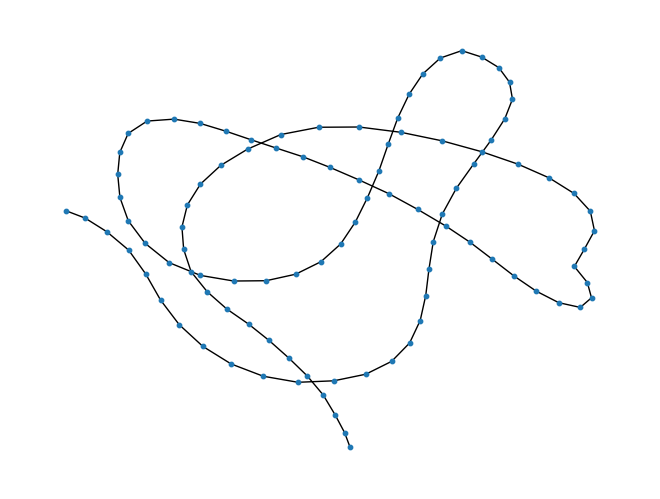

In [11]:
nx.draw(circuit_graph, node_size=10)

### Summary

Circuit graphs are a simplify circuits.

Count T-gate resources separately.

## Getting Resource Estimates from Circuit Graphs

circuit graph state + measurement = circuit implementation

At the physical level, how many qubits do we need?

At the logical level, how do we make the graph state?

### How many qubits do we need?

`find_min_viable_distance` tries a bunch of different code distances. (the power of the code)

Returns the number of physical qubits required to reach that distance.

In [12]:
from benchq.resource_estimation.graph_compilation import find_min_viable_distance

logical_qubit_count = len(circuit_graph)
distance = find_min_viable_distance(
    logical_qubit_count,
    architecture_model.physical_gate_error_rate, # physical error rate
    10e-3, # logical error rate
)

physical_qubit_count = 12 * logical_qubit_count * 2 * distance**2
total_time = 240 * logical_qubit_count * distance * 6 * architecture_model.physical_gate_time_in_seconds


print(f"distance: {distance}")
print(f"physical qubit count: {physical_qubit_count}")
print(f"total time: {total_time}")

4 inf
5 inf
6 inf
7 inf
8 inf
9 inf
10 inf
11 inf
12 116.18090346530532
13 55.500209856000026
14 18.976214232666536
15 7.172334812160005
16 2.2771457079199844
17 0.7823821890931206
18 0.25902532427589825
19 0.07790350995141128
20 0.024795586597350948
21 0.00774934914779828
distance: 21
physical_qubit_count: 1058400
3.024


### How to make Circuit Graph State?

Since graph state is a stabilizer state, we measure stabilizers to generate it!

We could measure all the stabilizers to get the graph.

Measurements are expensive!! So how optimize?

### Substrate Scheduler

Tells us how to measure and which can be measured simultaneously.

In [13]:
from benchq.resource_estimation.graph_compilation import substrate_scheduler

compiler = substrate_scheduler(circuit_graph)
formatted_measurement_steps = [[ node[0] for node in step]for step in compiler.measurement_steps]
print(compiler.measurement_steps)

pre-mapping optimization took - 2.050999682978727e-06s
node to patch mapping took    - 9.098999726120383e-06s
measurement scheduler took    - 0.00020605800000339514s
[[(4, (2, 4)), (7, (6, 8)), (11, (10, 12)), (15, (14, 16)), (19, (18, 20)), (23, (22, 24)), (27, (26, 28)), (31, (30, 32)), (35, (34, 36)), (39, (38, 40)), (43, (42, 44)), (47, (46, 48)), (51, (50, 52)), (55, (54, 56)), (59, (58, 60)), (63, (62, 64)), (67, (66, 68)), (71, (70, 72)), (75, (74, 76)), (79, (78, 80)), (83, (82, 84)), (87, (86, 88)), (91, (90, 92)), (95, (94, 96))], [(1, (0, 5)), (8, (7, 9)), (12, (11, 13)), (16, (15, 17)), (20, (19, 21)), (24, (23, 25)), (28, (27, 29)), (32, (31, 33)), (36, (35, 37)), (40, (39, 41)), (44, (43, 45)), (48, (47, 49)), (52, (51, 53)), (56, (55, 57)), (60, (59, 61)), (64, (63, 65)), (68, (67, 69)), (72, (71, 73)), (76, (75, 77)), (80, (79, 81)), (84, (83, 85)), (88, (87, 89)), (92, (91, 93)), (96, (95, 97))], [(5, (1, 6)), (9, (8, 10)), (13, (12, 14)), (17, (16, 18)), (21, (20, 22)

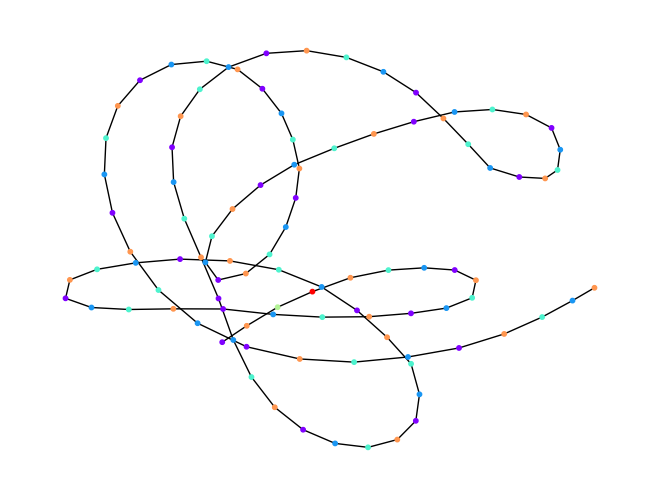

In [14]:
from benchq.vizualization_tools import plot_graph_state_with_measurement_steps

plot_graph_state_with_measurement_steps(compiler.input_graph, compiler.measurement_steps)

### Problem! Graph can get too big to handle!

#### Solution! Use subcircuits.

Quantum Algorithms are made up of repeated components.

Estimate resources for each component & multiply by the number of times it was used.

Will create a higher estimate.

More on this later!

## FINALLY! Pretty Graph Time!

Let's look at the graphs of circuits to examine measurement steps!

pre-mapping optimization took - 4.464000085135922e-06s
node to patch mapping took    - 5.810999937239103e-06s
measurement scheduler took    - 5.9171999964746647e-05s
4 inf
5 inf
6 inf
7 inf
8 inf
9 7.527814963200002
10 2.9506261197537857
11 1.2880927825920006
12 0.43374203960380653
13 0.15984060438528008
14 0.05060323795377743
15 0.01721360354918401
16 0.005667562650823073
17 0.0017070156852940816
18 0.0005419606784849563


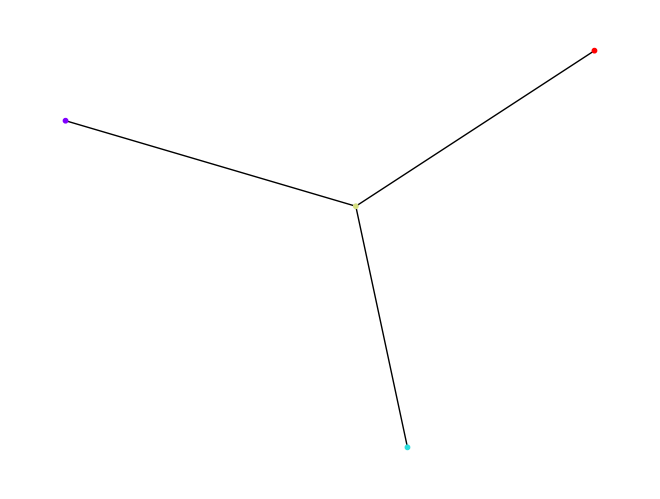

{'logical_error_rate': 0.0005419606784849563, 'total_time': 20.44713097075167, 'physical_qubit_count': 31104, 'min_viable_distance': 18, 'synthesis_error_rate': 1.129084746843659e-05, 'resources_in_cells': 9400320.0, 'n_measurement_steps': 4, 'graph_degree': 3}


In [19]:
circuit = QuantumCircuit.from_qasm_file("ghz_circuit.qasm")

clifford_t_circuit = pyliqtr_transpile_to_clifford_t(circuit, synthesis_accuracy=1e-10)
circuit_graph = get_algorithmic_graph(clifford_t_circuit)
ghz_resource_estimates = get_resource_estimations_for_graph(circuit_graph, architecture_model, 1e-3, plot=True)
print(ghz_resource_estimates)

pre-mapping optimization took - 4.120000085094944e-06s
node to patch mapping took    - 4.923000233247876e-06s
measurement scheduler took    - 2.579000010882737e-05s
4 inf
5 inf
6 inf
7 inf
8 inf
9 7.527814963200002
10 2.9506261197537857
11 1.2880927825920006
12 0.43374203960380653
13 0.15984060438528008
14 0.05060323795377743
15 0.01721360354918401
16 0.005667562650823073
17 0.0017070156852940816
18 0.0005419606784849563


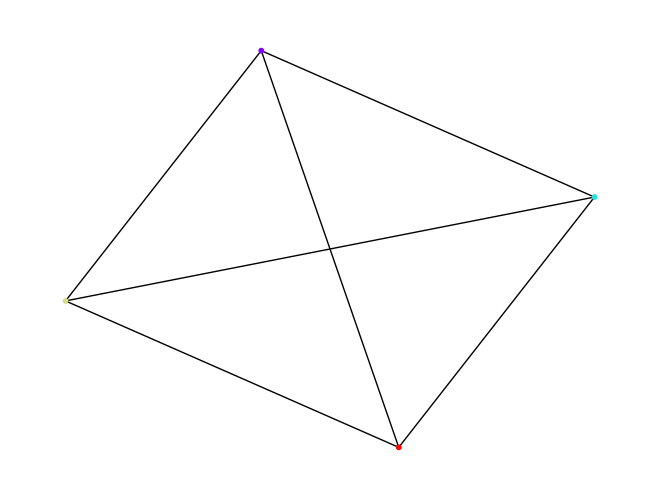

{'logical_error_rate': 0.0005419606784849563, 'total_time': 20.44713097075167, 'physical_qubit_count': 31104, 'min_viable_distance': 18, 'synthesis_error_rate': 1.129084746843659e-05, 'resources_in_cells': 9400320.0, 'n_measurement_steps': 4, 'graph_degree': 3}


In [20]:
circuit = QuantumCircuit.from_qasm_file("connected_circuit.qasm")

clifford_t_circuit = pyliqtr_transpile_to_clifford_t(circuit, synthesis_accuracy=1e-10)
circuit_graph = get_algorithmic_graph(clifford_t_circuit)
connected_resource_estimates = get_resource_estimations_for_graph(circuit_graph, architecture_model, 1e-3, plot=True)
print(connected_resource_estimates)

pre-mapping optimization took - 4.240999260218814e-06s
node to patch mapping took    - 0.0001000380007099011s
measurement scheduler took    - 0.006263149999540474s
4 inf
5 inf
6 inf
7 inf
8 inf
9 inf
10 inf
11 inf
12 inf
13 inf
14 6473.302827789684
15 2446.6784919346687
16 863.1070437052913
17 339.6805306302632
18 122.34542344522505
19 37.96429459985295
20 12.687673542467785
21 3.8184087884378415
22 1.2211885784625245
23 0.3828199580203067
24 0.1181222406803751
25 0.03426777117828833
26 0.01037196165974171
27 0.0031087722012943173
28 0.0009240474933224434


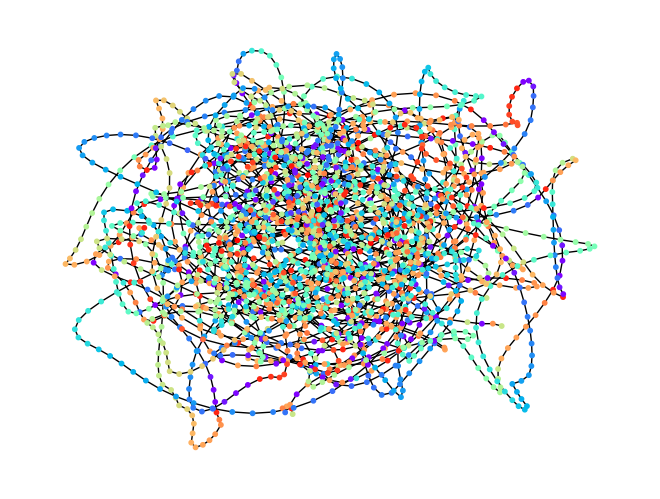

{'logical_error_rate': 0.0009240474933224434, 'total_time': 31614.5265966685, 'physical_qubit_count': 49147392, 'min_viable_distance': 28, 'synthesis_error_rate': 2.9480841415340845e-08, 'resources_in_cells': 6130465136640.0, 'n_measurement_steps': 107, 'graph_degree': 26}


In [22]:
circuit = QuantumCircuit.from_qasm_file("h_chain_circuit.qasm")

clifford_t_circuit = pyliqtr_transpile_to_clifford_t(circuit, synthesis_accuracy=1e-10)
circuit_graph = get_algorithmic_graph(clifford_t_circuit)
h_chain_resource_estimates = get_resource_estimations_for_graph(circuit_graph, architecture_model, 1e-3, plot=True)
print(h_chain_resource_estimates)

## Closing Statements

### What did we learn?


#### Inputs
- Circuit
- Architecture model
#### Outputs
- Number of physical qubits
- Computation time
- Number of measurement steps



#### Components:
- Transpilation (pyliqtr)
  - Bring to Clifford + T
- Jabalizer/ICM
  - Easy way to represent circuit
- Min code distance finding
  - Number of physical qubits
  - Computation time
- Substrate scheduling
  - number of measurement steps

## What's Next?

- How to get resource estimate for large algorithms? (QuantumPrograms)
- Compare to other resource estimators.
- Try this notebook out for yourself!!